# Prueba Grupo Hotusa

##### 1.Representa gráficamente el número de cancelaciones y reservas confirmadas para cada fecha de check in (date_checkin).
##### 2.Número de reservas confirmadas y cancelaciones para cada agencia (agengy_id). Selecciona únicamente el top 10 en cuanto a volumen total de reservas.
##### 3.Evolución del precio mínimo, precio medio, precio máximo y revenue para cada fecha de check in (date_checkin) (preferiblemente representadas en la misma gráfica superpuestas, revenue puede ir según la escala) (Nótese: revenue = mean_price_per_night * nights) Se puede extraer alguna conclusión al comparar la evolución entre los precios y el revenue. ¿Hay fechas mal vendidas?
##### 4.Las reservas entran con una antelación. La antelación se calcula como: date_checkin - date_gen. El objetivo de esta pregunta es observar como afecta la antelación a la cancelación y confirmación de las reservas. ¿Cuándo suelen entrar las reservas? ¿el ratio de cancelación es constante para diferentes antelaciones? (Si es posible agrupa las antelaciones en intervalos: [0,3),[3,7),[7,30),[30,90),[90,120] días)
##### 5.Elabora 2 análisis por tu parte: Algunas sugerencias: Diferencias entre precio de venta de reservas canceladas y confirmadas, cómo afecta el número de noches al precio medio de la reserva, ratio de cancelación por origen (origen_id), evolución del precio de venta por mes, qué considerarías outliers...

In [36]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
file_path = "hotusa_analysis.csv"
df = pd.read_csv(file_path)

### Reservas totales, confirmadas y canceladas por día.

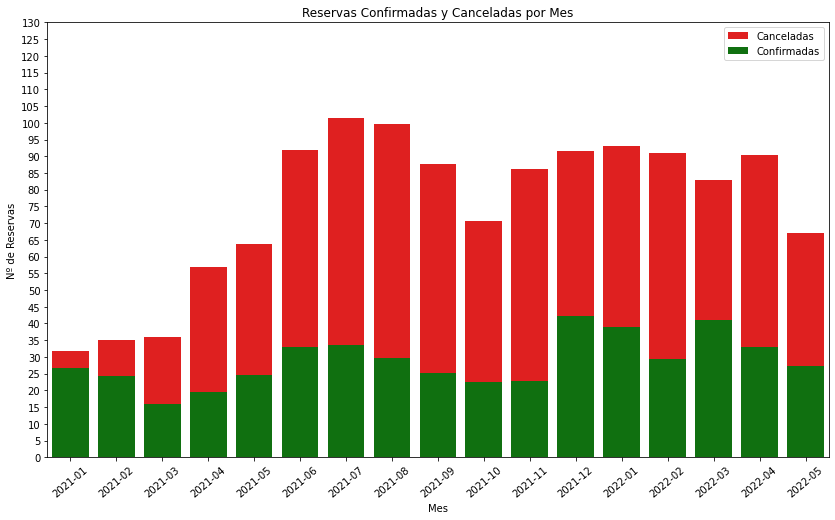

In [38]:
#Filtramos reservas confirmadas y canceladas, y por fecha.
reservas_confirmadas = df[df['status'] == 'Confirmed']
reservas_canceladas = df[df['status'] == 'Cancelled']

confirmadas_por_fecha = reservas_confirmadas.groupby('date_checkin').size().reset_index(name='confirmadas')
canceladas_por_fecha = reservas_canceladas.groupby('date_checkin').size().reset_index(name='canceladas')

datos_por_fecha = pd.merge(confirmadas_por_fecha, canceladas_por_fecha, on='date_checkin', how='outer').fillna(0) #Nuevo dataframe

datos_por_fecha = datos_por_fecha.sort_values(by='date_checkin') #Ordenamos por fecha de check-in

# Agregamos columna para el mes
datos_por_fecha['date_checkin'] = pd.to_datetime(datos_por_fecha['date_checkin'])
datos_por_fecha['month'] = datos_por_fecha['date_checkin'].dt.to_period('M')

plt.figure(figsize=(14, 8))
sns.barplot(x='month', y='canceladas', data=datos_por_fecha, color='red', label='Canceladas', errwidth=0)
sns.barplot(x='month', y='confirmadas', data=datos_por_fecha, color='green', label='Confirmadas', errwidth=0)
plt.xticks(rotation=40)
plt.xlabel('Mes')
plt.yticks(range(0, int(datos_por_fecha[['canceladas', 'confirmadas']].max().max()) - 60, 5))
plt.ylabel('Nº de Reservas')
plt.title('Reservas Confirmadas y Canceladas por Mes')
plt.legend()
plt.show()

##### En cuanto al acumulado: podemos ver un aumento de reservas en las épocas de verano (Junio, Julio, Agosto y Septiembre) del 2021 y en menor medida durante los meses de las fiestas Navideñas(Diciembre y Enero) de finales de 2021 y principios del 2022, despúes se ve también un pico de reservas en Abril, coincidiendo con la semana santa. En cuanto al primer trimestre del 2021, la cantidad tan baja de reservas probablemente viene marcada por el aún presente Coronavirus.

##### Una vez filtramos las reservas por las confirmadas y las canceladas, vemos como se correlacionan los picos de reservas, con los picos de las confirmadas, aunque a pesar de esto, se observa dentro de cada mes, un mayor peso de las cancelaciones sobre las confirmadas.

### Top 10 agencias por reservas

In [41]:
#Agrupamos por agencia y estado de reserva, y contamos nº de reservas
reservas_por_agencia = df.groupby(['agency_id', 'status']).size().reset_index(name='count')

#Filtramos solo las reservas confirmadas y canceladas, además sumamos nº total de reservas por agencia
reservas_confirmadas = reservas_por_agencia[reservas_por_agencia['status'] == 'Confirmed']
reservas_canceladas = reservas_por_agencia[reservas_por_agencia['status'] == 'Cancelled']
total_reservas_por_agencia = pd.merge(reservas_confirmadas, reservas_canceladas, on='agency_id', suffixes=('_confirm', '_cancel'))

#Total de reservas por agencia
total_reservas_por_agencia['total_reservas'] = total_reservas_por_agencia['count_confirm'] + total_reservas_por_agencia['count_cancel']

#Seleccionamos el top 10 por total de reservas
top_10_agencias = total_reservas_por_agencia.sort_values(by='total_reservas', ascending=False).head(10)
top_10_agencias = top_10_agencias.drop(['status_confirm', 'status_cancel'], axis=1)

top_10_agencias

,agency_id,count_confirm,count_cancel,total_reservas
0,Agencia_1,9633,17010,26643
8,Agencia_2,1888,8710,10598
14,Agencia_4,547,4568,5115
17,Agencia_5,637,2439,3076
20,Agencia_6,858,1966,2824
3,Agencia_12,490,1535,2025
11,Agencia_3,361,1030,1391
23,Agencia_8,126,502,628
22,Agencia_7,36,241,277
1,Agencia_10,122,95,217


### Evolución del precio medio, mínimo, máximo e ingresos por fecha

In [42]:
df['revenue'] = df['mean_price_per_night'] * df['nights'] #Creamos 'revenue'
preciototal_con_reserva = df[['date_checkin', 'revenue']].copy() #Nuevo DataFrame preciototal_con_reserva

preciototal_con_reserva['precio_max'] = df.groupby('date_checkin')['revenue'].transform('max') #Creamos precio maximo
preciototal_con_reserva['precio_min'] = df.groupby('date_checkin')['revenue'].transform('min') #Creamos precio mínimo
preciototal_con_reserva['precio_medio'] = df['mean_price_per_night'] #Creamos precio medio

sum_revenue_by_date = df.groupby('date_checkin')['revenue'].sum().reset_index(name='sum_revenue') #Suma de 'revenue' por fecha.

preciototal_con_reserva = pd.merge(preciototal_con_reserva, sum_revenue_by_date, on='date_checkin', how='left') #Fusionar las tablas
preciototal_con_reserva = preciototal_con_reserva.sort_values(by='date_checkin') #Ordenamos nuevo dataframe por fecha
preciototal_con_reserva = preciototal_con_reserva.drop_duplicates(subset='date_checkin', keep='first') #Borramos duplicados
preciototal_con_reserva = preciototal_con_reserva.drop('revenue', axis=1) #Eliminamos la columna 'revenue'

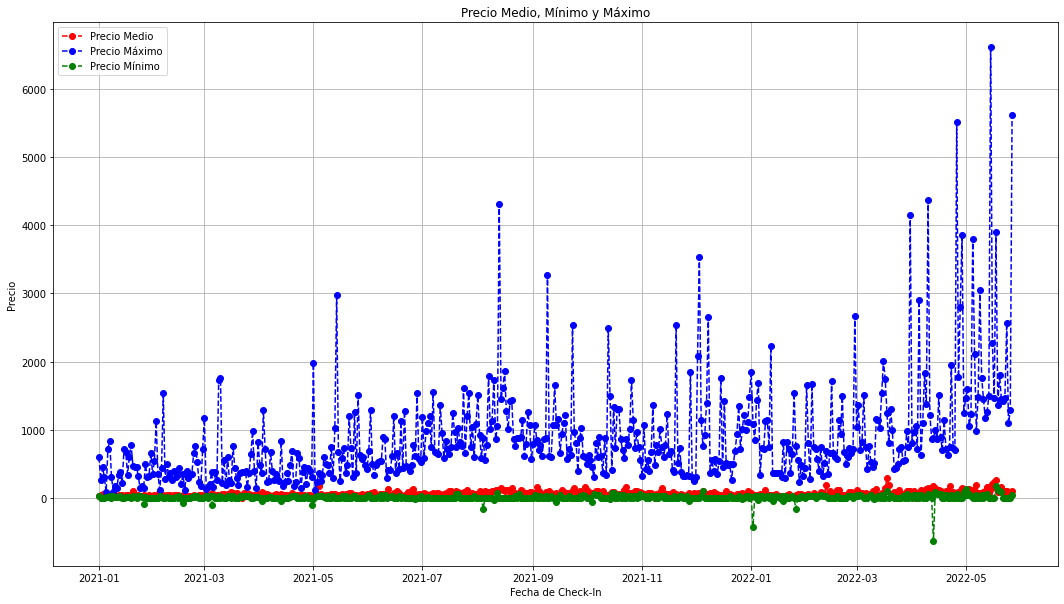

In [43]:
preciototal_con_reserva['date_checkin'] = pd.to_datetime(preciototal_con_reserva['date_checkin']) #Convertimos a formato fecha/hora
preciototal_con_reserva['month'] = preciototal_con_reserva['date_checkin'].dt.to_period('M') #Columna con el mes
preciototal_con_reserva = preciototal_con_reserva.sort_values(by='date_checkin') #Ordenamos por fecha

plt.figure(figsize=(18, 10))
plt.plot(preciototal_con_reserva['date_checkin'], preciototal_con_reserva['precio_medio'], marker='o', linestyle='--', color='red', label='Precio Medio')
plt.plot(preciototal_con_reserva['date_checkin'], preciototal_con_reserva['precio_max'], marker='o', linestyle='--', color='blue', label='Precio Máximo')
plt.plot(preciototal_con_reserva['date_checkin'], preciototal_con_reserva['precio_min'], marker='o', linestyle='--', color='green', label='Precio Mínimo')

plt.xlabel('Fecha de Check-In')
plt.ylabel('Precio')
plt.title('Precio Medio, Mínimo y Máximo')
plt.legend()
plt.grid(True)
plt.show()

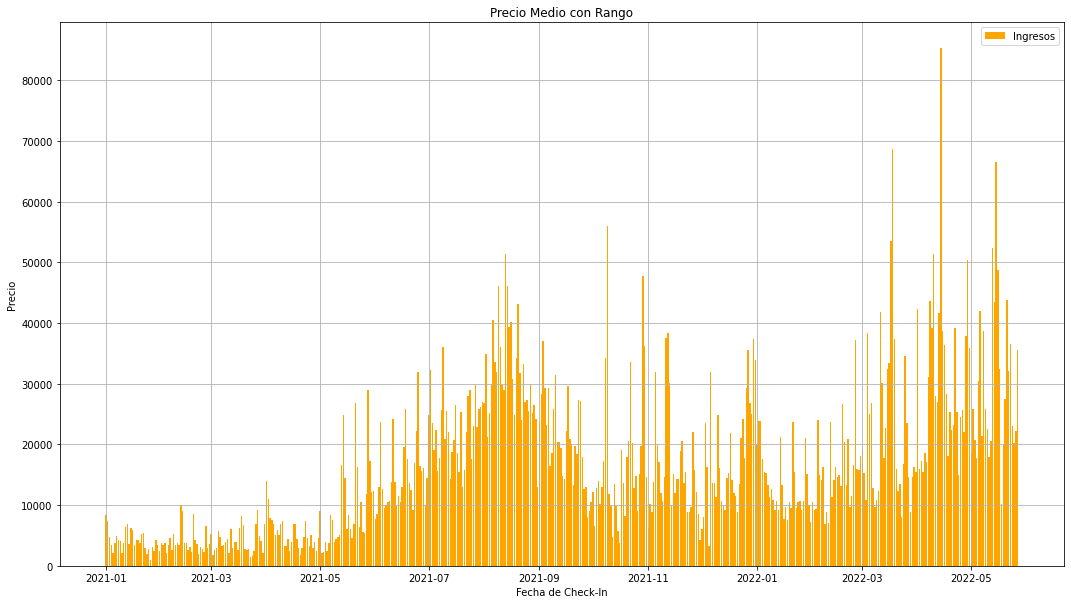

In [44]:
preciototal_con_reserva['date_checkin'] = pd.to_datetime(preciototal_con_reserva['date_checkin']) #Convertimos a formato fecha/hora
preciototal_con_reserva['month'] = preciototal_con_reserva['date_checkin'].dt.to_period('M') #Columna con el mes
preciototal_con_reserva = preciototal_con_reserva.sort_values(by='date_checkin') #Ordenamos por fecha

plt.figure(figsize=(18, 10))

plt.bar(preciototal_con_reserva['date_checkin'], preciototal_con_reserva['sum_revenue'], color='orange', label='Ingresos')

plt.xlabel('Fecha de Check-In')
plt.ylabel('Precio')
plt.title('Precio Medio con Rango')
plt.legend()
plt.grid(True)
plt.show()

### Ratio de cancelación por períodos de días de antelación.

In [45]:
#Convertimos las columnas 'date_gen' y 'date_checkin' a datetime
df['date_gen'] = pd.to_datetime(df['date_gen'])
df['date_checkin'] = pd.to_datetime(df['date_checkin'])


df['anticipation'] = (df['date_checkin'] - df['date_gen']).dt.days #Calculamos la antelación

#Creamos intervalos
bins = [0, 3, 7, 30, 90, 120]
labels = ['[0,3)', '[3,7)', '[7,30)', '[30,90)', '[90,120]']
df['anticipation_interval'] = pd.cut(df['anticipation'], bins=bins, labels=labels, right=False)

#Calculamos nº de reservas y cancelaciones por intervalo
counts = df.groupby('anticipation_interval')['status'].value_counts().unstack().fillna(0)

#Calculamos ratio de cancelación
counts['Cancellation_ratio_%'] = (counts['Cancelled'] / (counts['Cancelled'] + counts['Confirmed'])) * 100

print("Anticipación y Ratio de Cancelación:")
print(counts[['Cancelled', 'Confirmed', 'Cancellation_ratio_%']])


Anticipación y Ratio de Cancelación:
status                 Cancelled  Confirmed  Cancellation_ratio_%
anticipation_interval                                            
[0,3)                      16071       2212             87.901329
[3,7)                       7377       1920             79.348177
[7,30)                     10398       5177             66.760835
[30,90)                     3798       3426             52.574751
[90,120]                     376        548             40.692641


##### La tendencia nos dice que a medida que aumenta la antelación de la reserva, menor probabilidad de que la cancelen.

### Ratio de cancelación por origen

In [46]:
# Calcular el número de reservas y cancelaciones por origen y por intervalo de noches reservadas
counts = df.groupby(['ori_id', 'status']).size().unstack(fill_value=0)

# Calcular el ratio de cancelación
counts['cancellation_ratio_%'] = (counts['Cancelled'] / (counts['Cancelled'] + counts['Confirmed'])) * 100
counts = counts.sort_values(by='cancellation_ratio_%', ascending=False)

# Mostrar los resultados
print("Ratio de Cancelación por Origen:")
print(counts[['Cancelled', 'Confirmed', 'cancellation_ratio_%']])


Ratio de Cancelación por Origen:
status  Cancelled  Confirmed  cancellation_ratio_%
ori_id                                            
7               9          0            100.000000
10            702         11             98.457223
4            4050        661             85.969009
12            284         53             84.272997
11           8721       1887             82.211538
9             390        137             74.003795
13           4155       1576             72.500436
14          20210      10467             65.879975


### Análisis de la temporada alta: De 1 de Abril a 31 de Septiembre

In [47]:
df['date_checkin'] = pd.to_datetime(df['date_checkin']) #Convertimos columna 'date_checkin' a datetime

seasonal_df = df[(df['date_checkin'].dt.month >= 4) & (df['date_checkin'].dt.month <= 10)] #Filtramos reservas dentro de la época de temporada alta

#Agrupamos por mes y obtenemos las columnas del nuevo dataframe
monthly_df = pd.DataFrame({
    'reservations_count': seasonal_df.groupby(seasonal_df['date_checkin'].dt.to_period("M"))['res_id'].count(),
    'confirmed_sum': seasonal_df[seasonal_df['status'] == 'Confirmed'].groupby(seasonal_df['date_checkin'].dt.to_period("M"))['res_id'].count(),
    'cancelled_sum': seasonal_df[seasonal_df['status'] == 'Cancelled'].groupby(seasonal_df['date_checkin'].dt.to_period("M"))['res_id'].count(),
    'nights_sum': seasonal_df.groupby(seasonal_df['date_checkin'].dt.to_period("M"))['nights'].sum(),
    'mean_price_per_night_sum': (seasonal_df['mean_price_per_night'] * seasonal_df['nights']).groupby(seasonal_df['date_checkin'].dt.to_period("M")).sum()
}).reset_index()

monthly_df = monthly_df.rename(columns={'date_checkin': 'month'}) #Renombramos la columna 'date_checkin' a 'month'

monthly_df['mean_price_per_night'] = round(monthly_df['mean_price_per_night_sum'] / monthly_df['reservations_count'], 2)
monthly_df['mean_nights_per_reservation'] = round((monthly_df['nights_sum'] / monthly_df['reservations_count']), 1)
monthly_df['cancellation_ratio_%'] = round(((monthly_df['confirmed_sum'] / monthly_df['reservations_count']) * 100), 2)

monthly_df = monthly_df.drop(['mean_price_per_night_sum', 'nights_sum'], axis=1)

print("Análisis de la temporada alta(del 1/4 a 31/9):")
print(monthly_df)


Análisis de la temporada alta(del 1/4 a 31/9):
     month  reservations_count  confirmed_sum  cancelled_sum  \
0  2021-04                2293            590           1703   
1  2021-05                2740            765           1975   
2  2021-06                3750            990           2760   
3  2021-07                4183           1043           3140   
4  2021-08                4006            920           3086   
5  2021-09                3390            758           2632   
6  2021-10                2885            696           2189   
7  2022-04                3705            992           2713   
8  2022-05                2545            736           1809   

   mean_price_per_night  mean_nights_per_reservation  cancellation_ratio_%  
0                 69.80                          1.6                 25.73  
1                108.93                          1.9                 27.92  
2                118.79                          2.0                 26.40  
3   